In [1]:
from ModelClass import RegressionModel
from DatasetClass import Dataset, DatasetMass
import matplotlib.pyplot as plt
import numpy as np
import itertools
from src.helpers import make_filter_slice

2025-03-04 00:14:58.929517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-04 00:14:58.950864: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-04 00:14:58.957472: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-04 00:14:58.974419: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-04 00:15:03.877760: E external/local_xla/xla/

In [1]:
erik_data = "/scratch/ucjf-atlas/htautau/SM_Htautau_R22/V02_skim_mva_01/*/*/*/*/*H125*.root"
patrik_data = "/scratch/ucjf-atlas/htautau/SM_Htautau_R22/V02_skim_mva_01/*/*/*/*/*Ztt*.root"


In [2]:
dataset = Dataset(file_paths=erik_data, file_name = "erik_data")
dataset.load_data()

print(len(dataset.train_dataset))

#This block of code iterates through the dataset and extracts the pt values of the labels and stores them in a list
data = [labels.numpy()[0] for features, labels in dataset.train_dataset.take(100000)]

plt.hist(data, bins=100, range=(50, 130), histtype='step', label='pt distribution', density=False)
plt.legend(loc='upper right')
plt.title('pt distribution of the dataset')
plt.xlabel('pt')
plt.ylabel('Number of events')
plt.show()



NameError: name 'Dataset' is not defined

In [2]:
import tensorflow as tf
dataset = DatasetMass(file_name = "data_test")
dataset.load_data()



tf.Tensor([ 0  1  2  3  4  5  6  7 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28], shape=(24,), dtype=int64)
tf.Tensor(
[[ 9.0357765e+01 -7.8804618e-01  1.0913507e+00  0.0000000e+00
   1.1544228e+02 -6.3030320e-01  5.1007485e-01  5.1099859e-04
   1.5774298e-01  5.8127582e-01  6.0229927e-01  3.7529095e+02
   2.0580005e+02  4.6831229e+02  6.3583905e-01 -2.0103385e+00
   2.3403393e+01  1.8591090e+02  3.5445452e-01  2.2494874e+00
   2.6615793e+01  4.2158942e+02  8.1958336e-01 -2.4181299e+00
   5.1056644e+02  1.7842209e+02  0.0000000e+00  8.6021674e-01
  -5.4045435e-02  3.0000000e+00  3.0000000e+00  3.0000000e+00
   1.0000000e+00  0.0000000e+00  1.0000000e+00]], shape=(1, 35), dtype=float32)
tf.Tensor([97.74853], shape=(1,), dtype=float32)


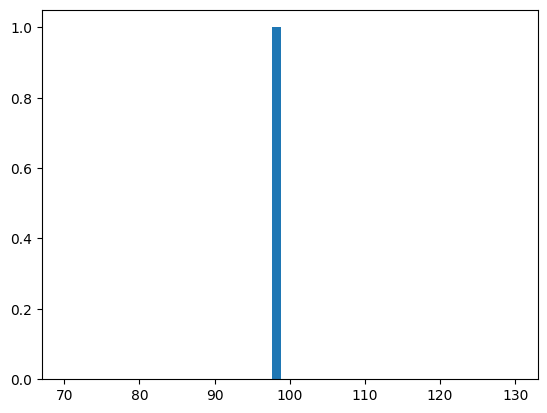

In [6]:
import tensorflow as tf

dataset.make_slices(n_slices=35)
slices = dataset.slices   

lorentz_mask = tf.constant(dataset.get_lorentz_mask())  # Shape [35]
lorentz_indices = tf.squeeze(tf.where(lorentz_mask), axis=1) 
print(lorentz_indices)
n_vectors = tf.shape(lorentz_indices)[0] // 4
lorentz_indices_4d = tf.reshape(lorentz_indices, (n_vectors, 4))  # [n_vectors, 4]

@tf.function
def augment_lorentz(data, target):
    beta = tf.random.uniform(shape=(tf.shape(data)[0],), minval=0.0, maxval=1.0)
    gamma = 1.0 / tf.sqrt(1.0 - beta**2)
    
    # Extract 4-vectors using indices
    boosted_data = data
    for i in range(n_vectors):
        vec_indices = lorentz_indices_4d[i]
        print(vec_indices)
        pt = data[vec_indices[0]]
        eta = data[vec_indices[1]]
        phi = data[vec_indices[2]]
        E = data[vec_indices[3]]
        
        # Convert to Cartesian coordinates
        px = pt * tf.cos(phi)
        py = pt * tf.sin(phi)
        pz = pt * tf.sinh(eta)
        
        # Apply boost along z-axis
        beta_exp = tf.expand_dims(beta, 1)
        gamma_exp = tf.expand_dims(gamma, 1)
        E_prime = gamma_exp * (E - beta_exp * pz)
        pz_prime = gamma_exp * (pz - beta_exp * E)
        
        # Convert back to eta
        epsilon = 1e-8
        eta_prime = tf.asinh(pz_prime / (pt + epsilon))

        boosted_data = tf.tensor_scatter_nd_update(
            boosted_data,
            indices=tf.expand_dims(vec_indices, axis=1),
            updates=tf.stack([pt, eta_prime, phi, E_prime], axis=0)
        )
        
    return boosted_data, target

n_events = 1
new_dataset = tf.data.Dataset.sample_from_datasets([s.repeat() for s in slices], weights=[1.]*len(slices))
new_dataset = new_dataset.take(n_events)
batch_dataset = new_dataset.batch(n_events)

features, masses = next(iter(batch_dataset))
print(features)
print(masses)


import matplotlib.pyplot as plt
plt.hist(masses, range=(70, 130), bins=50)
plt.show()



tf.Tensor(
[False False  True False False False  True False False  True False False
 False False False  True False False False  True False False False  True
 False False False  True False False False False False False False], shape=(35,), dtype=bool)
tf.Tensor(
[ True  True  True  True  True  True  True  True False False False False
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False False False False False], shape=(35,), dtype=bool)


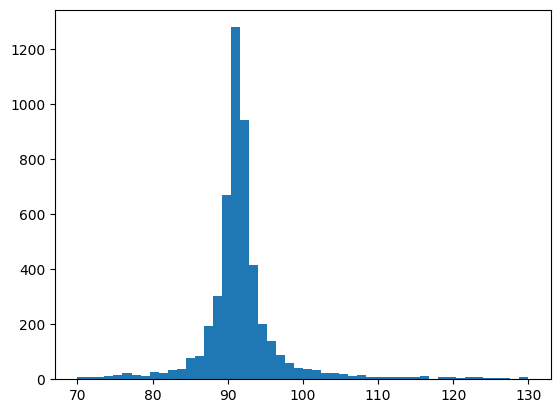

In [8]:

import vector as v

# augmentation
dataset.make_slices(n_slices=1)
slices = dataset.slices 

phi_mask = tf.constant(dataset.get_phi_mask())
lorentz_mask = tf.constant(dataset.get_lorentz_mask())
print(phi_mask)
print(lorentz_mask)

@tf.function
def augment_phi(data, target):
    # generate random rotation angle
    angle = tf.random.uniform(shape=(tf.shape(data)[0],), minval=-np.pi, maxval=np.pi)

    # apply rotation
    data  = tf.where(phi_mask[tf.newaxis, :], data + angle[:, tf.newaxis], data)

    # normalize angles between -pi and pi
    data = tf.where(phi_mask[tf.newaxis, :], tf.math.atan2(tf.sin(data), tf.cos(data)), data)

    return data, target

# sample from the slices
n_events = 5000
new_dataset = tf.data.Dataset.sample_from_datasets([s.repeat() for s in slices], weights=[1.]*len(slices))
new_dataset = new_dataset.take(n_events)

# apply augmentation
new_dataset = new_dataset.map(augment_phi)

batch_dataset = new_dataset.batch(n_events)
#print(batch_dataset.take(1))
#print(type(batch_dataset))
#@tf.function
#def pick_mass(data, targets):
#        return data, targets

features, targets = next(iter(batch_dataset))
masses = targets

import matplotlib.pyplot as plt
plt.hist(masses, range=(70, 130), bins=50)
plt.show()




tf.Tensor(
[False False  True False False False  True False False  True False False
 False False False  True False False False  True False False False  True
 False False False  True False False False False False False False], shape=(35,), dtype=bool)
tf.Tensor(
[ True  True  True  True  True  True  True  True False False False False
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False False False False False], shape=(35,), dtype=bool)


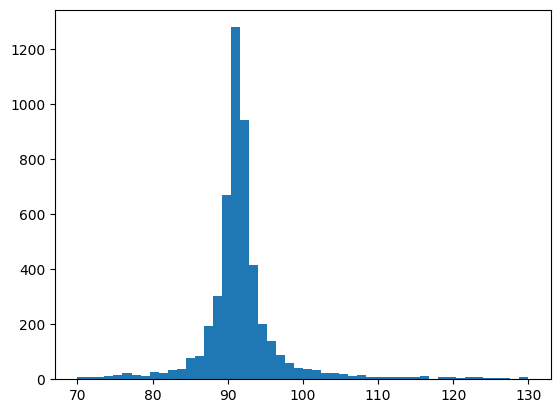

In [ ]:

import vector as v

# augmentation
dataset.make_slices(n_slices=1)
slices = dataset.slices 

phi_mask = tf.constant(dataset.get_phi_mask())
lorentz_mask = tf.constant(dataset.get_lorentz_mask())
print(phi_mask)
print(lorentz_mask)

@tf.function
def augment_phi(data, target):
    # generate random rotation angle
    angle = tf.random.uniform(shape=(tf.shape(data)[0],), minval=-np.pi, maxval=np.pi)

    # apply rotation
    data  = tf.where(phi_mask[tf.newaxis, :], data + angle[:, tf.newaxis], data)

    # normalize angles between -pi and pi
    data = tf.where(phi_mask[tf.newaxis, :], tf.math.atan2(tf.sin(data), tf.cos(data)), data)

    return data, target

@tf.function
def augment_lorentz(data, target):
    beta = tf.random.uniform(shape=(tf.shape(data)[0],), minval=0, maxval=1)

    pxs = tf.where(lorentz_mask[tf.newaxis, :], data[:, 0], 0)
    pys = tf.where(lorentz_mask[tf.newaxis, :], data[:, 1], 0)
    pzs = tf.where(lorentz_mask[tf.newaxis, :], data[:, 2], 0)
    Es = tf.where(lorentz_mask[tf.newaxis, :], data[:, 3], 0)

    return data, target

# sample from the slices
n_events = 5000
new_dataset = tf.data.Dataset.sample_from_datasets([s.repeat() for s in slices], weights=[1.]*len(slices))
new_dataset = new_dataset.take(n_events)

# apply augmentation
new_dataset = new_dataset.map(augment_phi)

batch_dataset = new_dataset.batch(n_events)
#print(batch_dataset.take(1))
#print(type(batch_dataset))
#@tf.function
#def pick_mass(data, targets):
#        return data, targets

features, targets = next(iter(batch_dataset))
masses = targets

import matplotlib.pyplot as plt
plt.hist(masses, range=(70, 130), bins=50)
plt.show()




In [ ]:
dataset = Dataset(file_paths=erik_data, file_name = "erik_data")
dataset.load_data()

print(len(dataset.train_dataset))
param_grid = {
    'batch_size': [32, 64, 128],
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs': [10, 20, 30]
}

iterable = list(itertools.product(*param_grid.values()))
for params in iterable:
    model = RegressionModel(dataset=dataset, batch_size=params[0], initial_learning_rate=params[1], n_epochs=params[2])
    model.prepare_dataset()
    model.create_normalizer()
    model.build_model()
    model.train_model(model.train_batch, model.val_batch)
    model.plot_history(model.history)

6523673
Batching datasets...
Building model...
Training model...
Epoch 1/10


2025-01-29 01:07:34.276361: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


203865/203865 ━━━━━━━━━━━━━━━━━━━━ 220s 1ms/step - loss: 6972.8779 - mean_squared_error: 6972.8779 - val_loss: 6874.8071 - val_mean_squared_error: 6874.8286
Epoch 2/10
203825/203865 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 6946.1182 - mean_squared_error: 6946.1182